# Creating A 3-Layer Neural Network (MLP) from Scratch

Using it to binary classify bag vs not bag

In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
!curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz
!tar -x -z -f /tmp/data.tar.gz
!rm -f /tmp/data.tar.gz

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)


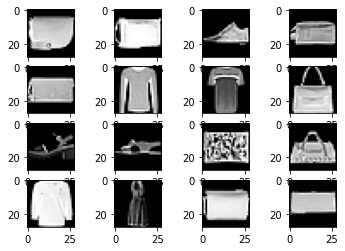

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        img = trainxs[np.random.randint(0, len(trainxs))]
        axarr[i, j].imshow(img)

In [11]:
def sigmoid(z):
    """Compute the logistic function"""
    return 1. / (1. + np.exp(-z))
def sigmoid_d(z):
    """Compute derivative of the logistic function"""
    fz = sigmoid(z)
    return fz * (1 - fz)
def loss(yhat, y):
    """Single sample log-likelihood loss"""
    if yhat in (0, 1): # Check if sample will cause ln(0)
        return np.array([[0]])
    return (-y * np.log(yhat)) - ((1 - y) * np.log(1 - yhat))

In [12]:
def forward(params, x):
    """Compute Forward Pass"""
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["W2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    forward_res["z3"] = params["W3"] @ forward_res["a2"] + params["b3"]
    forward_res["a3"] = sigmoid(forward_res["z3"])
    
    return forward_res

def backprop(x, y, params):
    """Compute Gradients"""
    x = x.reshape(28**2, 1)
    
    fwd_pass = forward(params, x)
    
    # Backwards Pass
    dL_dz3 = (fwd_pass["a3"] - y)
    dL_dz2 = dL_dz3.dot(params["W3"]).T * sigmoid_d(fwd_pass["z2"])
    dL_dz1 = dL_dz2.T.dot(params["W2"]).T * sigmoid_d(fwd_pass["z1"])
    
    grad = {}
    grad["W3"] = dL_dz3.dot(fwd_pass["a2"].T)
    grad["b3"] = dL_dz3
    grad["W2"] = dL_dz2.dot(fwd_pass["a1"].T)
    grad["b2"] = dL_dz2
    grad["W1"] = dL_dz1.dot(x.T)
    grad["b1"] = dL_dz1

    return grad

In [13]:
def predict_raw(x, params):
    """Get raw model activation for given training sample"""
    forward_res = forward(params, x)
    return forward_res["a3"]

def predict_class(yhat):
    """Get class prediction for given activation"""
    if yhat >= 0.5:
        return 1
    return 0

## Gradient Checking

In [14]:
# Finite Differences Helper functions
def init_empty_params(m):
    """Return a copy of model parameters filled with zeros"""
    grad = {}
    for k in m:
        grad[k] = np.zeros_like(m[k])
    return grad

def flatten(m):
    """Compress model parameters into a 1D array"""
    toflatten = (m["W1"], m["b1"], m["W2"], m["b2"], m["W3"], m["b3"])
    vec = np.zeros(sum([x.size for x in toflatten]))
    offset = 0
    for param in toflatten:
        vec[offset:offset + param.size] = param.reshape(param.size)
        offset += param.size
    return vec

def unflatten(m, vec):
    """Uncompress 1D array of model parameters into dictionary"""
    params = (m["W1"], m["b1"], m["W2"], m["b2"], m["W3"], m["b3"])
    offset = 0
    for param in params:
        param[:] = vec[offset:offset + param.size].reshape(param.shape)
        offset += param.size
    return m

In [15]:
def run_fd(x, y, m):
    """Return the finite difference estimation of the gradients"""
    eps = 1e-6
    vecm = flatten(m)
    gradm = init_empty_params(m)
    vecgradm = flatten(gradm)
    for i in range(vecm.size):
        wi = vecm[i]
        vecm[i] += eps
        yhat = predict_raw(x, unflatten(init_empty_params(m), vecm))
        u = loss(yhat, y)
        vecm[i] = wi
        vecm[i] -= eps
        yhat = predict_raw(x, unflatten(init_empty_params(m), vecm))
        l = loss(yhat, y)
        vecgradm[i] = ((u - l) / (2 * eps))
        
        vecm[i] = wi
    return unflatten(gradm, vecgradm)

def compare_gradients(xs, ys, i):
    """Prints True for every correct grad"""
    x, y = xs[i], ys[i]
    img_size, h2, h1, out_size = 784, 199, 19, 1
    params = {
        "W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
        "b1": np.zeros((h1, 1)),
        "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
        "b2": np.zeros((h2, 1)),
        "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
        "b3": np.zeros((out_size, 1))
    }
    bp_an = backprop(x, y, params)
    bp_fd = run_fd(x, y, params)
    for k in bp_an:
        print(np.allclose(bp_an[k], bp_fd[k]))
compare_gradients(trainxs, trainys, 420)
compare_gradients(trainxs, trainys, 42)

True
True
True
True
True
True
True
True
True
True
True
True


# Implementing the Learning Algorithm

In [16]:
def nvalidate(xs, ys, params):
    """Returns (Dataset Loss, Dataset Accuracy)"""
    l, accuracy = 0, 0
    nData = xs.shape[0]
    for i in range(nData):
        yhat = predict_raw(xs[i], params) # Raw activation
        y_pred = predict_class(yhat) # Class prediction (binary)
        # Add Log Likelihood Loss
        if yhat not in (0, 1):
            l += (-ys[i] * np.log(yhat)) - ((1 - ys[i]) * np.log(1 - yhat))
        if y_pred == ys[i]:
            accuracy += 1
    return l.item() / nData, accuracy / nData

In [17]:
def train_three_layer_perceptron(
    xs, ys, devxs, devys, 
    n_epochs=3, learning_rate=0.1, 
    momentum=0, batch_size=0, 
    h1=19, h2=199):
    """Initialize and train model on a dataset, outputting validation set accuracy/loss"""
    img_size = 28**2
    out_size = 1
    nData = xs.shape[0]

    lr = learning_rate
    a = momentum # alpha

    # Enable Full Batch (set batch size 1 for s.g.d.)
    if batch_size == 0:
        batch_size = nData

    print("nData:", nData, "Hidden Layer 1 size:", h1, "Hidden Layer 2 size:", h2, "Learning Rate:", lr, "Momentum:", momentum, "Batch Size:", batch_size)

    # Initialize training metadata containers
    epochs = []
    t_losses, v_losses = [], []
    t_accs, v_accs = [], []

    # Initialize model parameters
    params = {"W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h1, 1)),
              "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
              "b2": np.zeros((h2, 1)),
              "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
              "b3": np.zeros((out_size, 1))}
    
    # Initialize Grad vector
    grad = {}
    # Initialize Update Vector nu
    v = {}
    for theta in params:
        v[theta] = np.zeros_like(params[theta])
    
    for epoch in range(n_epochs):
        epochs.append(epoch)
        print("----------------------------------\nEpoch:", epoch)
        v_loss, v_acc = nvalidate(devxs, devys, params)
        v_accs.append(v_acc)
        v_losses.append(v_loss)
        print("Val Acc:", v_acc, "Val Loss:", v_loss)
        
        # Randomly shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]

        # Get array of arrays containing batch_size array indices
        batch_indices = np.split(np.arange(nData), (nData // batch_size))
        
        for batch in batch_indices:
            # Initialize gradients to zero
            for theta in params:
                grad[theta] = np.zeros_like(params[theta])
            
            for i in batch:
                # Perform backprop to obtain gradients
                grad_i = backprop(trainxs_shuffled[i], trainys_shuffled[i], params)

                # Update batch gradient with incremental gradient
                for theta in grad_i:
                    grad[theta] += grad_i[theta] / batch_size
  
            # Perform exponentially averaged momentum update
            for theta in v:
                v[theta] = a * v[theta] + (1-a) * grad[theta] 
            
            # Perform model parameter update
            for theta in params:
                params[theta] -= lr * v[theta]
        
        
    return epochs, t_losses, t_accs, v_losses, v_accs, params

In [18]:
_ = train_three_layer_perceptron(
    trainxs, trainys, 
    devxs, devys,
    n_epochs=10,
    learning_rate=0.1,
    momentum=0.2,
    batch_size=1,
    h1=19,
    h2=199,
)

nData: 12000 Hidden Layer 1 size: 19 Hidden Layer 2 size: 199 Learning Rate: 0.1 Momentum: 0.2 Batch Size: 1
----------------------------------
Epoch: 0
Val Acc: 0.495 Val Loss: 0.7096211492945725
----------------------------------
Epoch: 1
Val Acc: 0.984 Val Loss: 0.06892773135534518
----------------------------------
Epoch: 2
Val Acc: 0.98 Val Loss: 0.07149641154727521
----------------------------------
Epoch: 3
Val Acc: 0.984 Val Loss: 0.09203535056671258
----------------------------------
Epoch: 4
Val Acc: 0.983 Val Loss: 0.06019776415438719
----------------------------------
Epoch: 5
Val Acc: 0.979 Val Loss: 0.0741491779602702
----------------------------------
Epoch: 6
Val Acc: 0.976 Val Loss: 0.06690461555239777
----------------------------------
Epoch: 7
Val Acc: 0.974 Val Loss: 0.07176505275443684
----------------------------------
Epoch: 8
Val Acc: 0.983 Val Loss: 0.07193551186332577
----------------------------------
Epoch: 9
Val Acc: 0.977 Val Loss: 0.08247248906993437


In [ ]:
def grid_search(mts, lrs, bzs, hzs, epchns):
    """Perform a hyperparameter grid search"""
    # Recall previous results from file
    gridsearch = {}
    try:
        with open("gridsearch.p", "rb") as fp:
            gridsearch = pickle.load(fp)
    except:
        print("No pickle file found, continuing...")
    for hz in hzs:
        for mt in mts:
            for lr in lrs:
                for bz in bzs:
                    for epchn in epchns:
                        key = "hids{}_momt{}_lr{}_bchsz{}_epch{}"\
                            .format(hz, mt, lr, bz, n_epochs)
                        print("Running", key)
                        if key in gridsearch.keys():
                            print("Skipping", key)
                            continue
                        gridsearch[key] = train_two_layer_perceptron(
                        trainxs, trainys,
                        devxs, devys,
                        n_epochs=epchn,
                        learning_rate=lr,
                        momentum=mt,
                        batch_size=bz,
                        h1=hz[0], h2=hz[1]
                        )
                        with open("gridsearch.p", "wb") as fp:
                            pickle.dump(gridsearch, fp,
                            protocol=pickle.HIGHEST_PROTOCOL)
momentums = [0, 0.2, 0.4]
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [1, 8, 1000, 12000]
hidden_layer_sizes = [(43, 19), (37, 23)]
epoch_ns = [50, 100, 300]
grid_search(momentums, learning_rates, batch_sizes, hidden_layer_sizes, epoch_ns)